Simplified Ising model on a square lattice, with and without an external magnetic field.

The first several cells use a simulation is implemented with numba, for increased effeciency. Further results are demonstrated using a numpy simulation. 

Cell structure: 
1. Functions for implementing square Ising model in numba, external field classes, data analysis and visualizations.
2. Simulation of the phase transition, compared with theoretical curve.
3. Simulate model evolution with UT-shaped external field.
4. Simulate model evolution with time-dependent oscillating field.
5. Functions and classes for implementing square Ising model in numpy, with external field classes.
6. Simulation of the phase transition, compared with theoretical curve (low res)
7. Simulation of magnetization over time in a time-dependent oscialting field.
8. Simulation of model evolution with spatially dependent external field, including animation. 

In [ ]:
###---Square Ising model implemented in numba, 
# with external field classes, data analysis, and visualizations

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
import numba
from numba import njit
from numpy.random import randint


# NUMBA-OPTIMIZED FUNCTIONS
@njit("Tuple((f8[:], f8[:], i8[:, :]))(i8, i8[:,:], i8, f8, i8)", nogil=True)
def _metropolis_basic_numba(N, spin_arr, times, BJ, E):
    """Numba-optimized basic Metropolis (zero external field)"""
    spin_arr_copy = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)

    for t in range(0, times-1):
        x = randint(0, N)
        y = np.random.randint(0, N)
        spin_i = spin_arr_copy[x, y]
        spin_f = -spin_i

        neighbors = [(x-1, y), ((x+1)%N, y), (x, y-1), (x, (y+1)%N)]
        E_i = sum([-spin_i * spin_arr_copy[nx, ny] for nx, ny in neighbors])
        E_f = sum([-spin_f * spin_arr_copy[nx, ny] for nx, ny in neighbors])

        dE = E_f - E_i
        if dE > 0 and np.random.random() < np.exp(-BJ * dE):
            spin_arr_copy[x, y] = spin_f
            E += dE
        elif dE <= 0:
            spin_arr_copy[x, y] = spin_f
            E += dE

        net_spins[t] = spin_arr_copy.sum()
        net_energy[t] = E

    return net_spins, net_energy, spin_arr_copy


# EXTERNAL FIELD CLASSES

class ExternalField:
    """Base class for external fields"""

    def time_dependent(self, t):
        """Time-dependent component H(t)"""
        return 0.0

    def position_dependent(self, size):
        """Position-dependent component H[i,j]"""
        return np.zeros((size, size))


class ZeroField(ExternalField):
    """No external field"""
    pass


class UTField(ExternalField):
    """UT-shaped position-dependent field"""

    def __init__(self, H0=2.0):
        self.H0 = H0

    def position_dependent(self, size):
        """Create UT-shaped field pattern"""
        H = np.zeros((size, size), dtype=float)

        t = max(1, size // 25)
        top = size // 5
        bottom = 4 * size // 5

        # U letter
        u_left = size // 10
        u_right = size // 3
        H[top:bottom, u_left:u_left + t] = self.H0
        H[top:bottom, u_right - t:u_right] = self.H0
        H[bottom - t:bottom, u_left:u_right] = self.H0

        # T letter
        t_left = size // 2
        t_right = 9 * size // 10
        H[top:top + t, t_left:t_right] = self.H0
        t_center = (t_left + t_right) // 2
        H[top:bottom, t_center - t // 2 : t_center + (t + 1) // 2] = self.H0

        return H


class OscillatingField(ExternalField):
    """Time-dependent oscillating field"""

    def __init__(self, amplitude=10.0, omega=0.00005):
        self.amplitude = amplitude
        self.omega = omega

    def time_dependent(self, t):
        """Cosine oscillation"""
        return self.amplitude * np.cos(np.pi * self.omega * t)


class ConstantField(ExternalField):
    """Constant external field"""

    def __init__(self, strength=1.0):
        self.strength = strength

    def time_dependent(self, t):
        return self.strength

# MAIN ISING MODEL CLASS

class IsingModel:
    """
    2D Ising Model with external fields

    Parameters
    ----------
    N : int
        Lattice size (N x N)
    temperature : float
        Temperature in units of J/k
    external_field : ExternalField, optional
        External field object
    """

    def __init__(self, N, temperature=1.0, external_field=None):
        self.N = N
        self.temperature = temperature
        self.BJ = 1.0 / temperature
        self.lattice = None
        self.external_field = external_field or ZeroField()

        # Cache position-dependent field
        self._H_pos = self.external_field.position_dependent(N)

        # History tracking
        self.spins_history = None
        self.energy_history = None
        self.snapshots = None
        self.snapshot_times = None

    def initialize_lattice(self, threshold=0.5):
        """
        Initialize lattice with random spins

        Parameters
        ----------
        threshold : float
            Fraction of spin-up sites (0.5 = random, 1.0 = all up, 0.0 = all down)
        """
        init_random = np.random.random((self.N, self.N))
        self.lattice = np.where(init_random >= threshold, 1, -1)
        return self.lattice

    def calculate_energy(self, lattice=None):
        """
        Calculate total energy from nearest-neighbor interactions
        Uses convolution with periodic boundary conditions
        """
        if lattice is None:
            lattice = self.lattice

        kernel = generate_binary_structure(2, 1)
        kernel[1][1] = False
        total = -lattice * convolve(lattice, kernel, mode='wrap', cval=0)
        return total.sum()

    def metropolis_basic(self, timesteps):
        """
        Run Metropolis algorithm without external field (uses Numba optimization)

        Parameters
        ----------
        timesteps : int
            Number of Monte Carlo steps

        Returns
        -------
        tuple
            (spins_history, energy_history, final_lattice)
        """
        if self.lattice is None:
            self.initialize_lattice()

        E = self.calculate_energy()
        spins, energies, final = _metropolis_basic_numba(
            self.N, self.lattice, timesteps, self.BJ, E
        )

        self.spins_history = spins
        self.energy_history = energies
        self.lattice = final

        return spins, energies, final

    def metropolis_with_field(self, timesteps):
        """
        Run Metropolis algorithm with external field

        Parameters
        ----------
        timesteps : int
            Number of Monte Carlo steps

        Returns
        -------
        tuple
            (spins_history, energy_history, final_lattice)
        """
        if self.lattice is None:
            self.initialize_lattice()

        spin_arr_copy = self.lattice.copy()
        E = self.calculate_energy()
        net_spins = np.zeros(timesteps - 1)
        net_energy = np.zeros(timesteps - 1)

        for t in range(0, timesteps - 1):
            # Pick random spin
            x = randint(0, self.N)
            y = np.random.randint(0, self.N)
            spin_i = spin_arr_copy[x, y]
            spin_f = -spin_i

            # Compute energy change from neighbors
            neighbors = [(x - 1, y), ((x + 1) % self.N, y),
                        (x, y - 1), (x, (y + 1) % self.N)]
            E_i = sum([-spin_i * spin_arr_copy[nx, ny] for nx, ny in neighbors])
            E_f = sum([-spin_f * spin_arr_copy[nx, ny] for nx, ny in neighbors])

            # Include field contributions
            dE = E_f - E_i
            H_t = self.external_field.time_dependent(t)
            deltaE = dE - H_t * (spin_f - spin_i) - self._H_pos[x, y] * (spin_f - spin_i)

            # Metropolis acceptance
            if deltaE > 0 and np.random.random() < np.exp(-self.BJ * deltaE):
                spin_arr_copy[x, y] = spin_f
                E += dE
            elif deltaE <= 0:
                spin_arr_copy[x, y] = spin_f
                E += dE

            # Total energy including fields
            E_tot = E - (H_t * np.sum(spin_arr_copy) + np.sum(self._H_pos * spin_arr_copy))
            net_spins[t] = spin_arr_copy.sum()
            net_energy[t] = E_tot

        self.spins_history = net_spins
        self.energy_history = net_energy
        self.lattice = spin_arr_copy

        return net_spins, net_energy, spin_arr_copy

    def metropolis_with_snapshots(self, timesteps, snapshot_interval=1000):
        """
        Run Metropolis with periodic snapshots for visualization

        Parameters
        ----------
        timesteps : int
            Number of Monte Carlo steps
        snapshot_interval : int
            Save snapshot every N steps

        Returns
        -------
        tuple
            (spins_history, energy_history, final_lattice, snapshots, snapshot_times)
        """
        if self.lattice is None:
            self.initialize_lattice()

        spin_arr_copy = self.lattice.copy()
        E = self.calculate_energy()
        net_spins = np.zeros(timesteps - 1)
        net_energy = np.zeros(timesteps - 1)

        # Store snapshots
        num_snapshots = timesteps // snapshot_interval
        snapshots = np.zeros((num_snapshots, self.N, self.N))
        snapshot_times = []
        snapshot_idx = 0

        for t in range(0, timesteps - 1):
            # Save snapshot at intervals
            if t % snapshot_interval == 0 and snapshot_idx < num_snapshots:
                snapshots[snapshot_idx] = spin_arr_copy.copy()
                snapshot_times.append(t)
                snapshot_idx += 1

            # Pick random spin
            x = randint(0, self.N)
            y = np.random.randint(0, self.N)
            spin_i = spin_arr_copy[x, y]
            spin_f = -spin_i

            # Compute energy change
            neighbors = [(x - 1, y), ((x + 1) % self.N, y),
                        (x, y - 1), (x, (y + 1) % self.N)]
            E_i = sum([-spin_i * spin_arr_copy[nx, ny] for nx, ny in neighbors])
            E_f = sum([-spin_f * spin_arr_copy[nx, ny] for nx, ny in neighbors])

            # Include field contributions
            dE = E_f - E_i
            H_t = self.external_field.time_dependent(t)
            deltaE = dE - H_t * (spin_f - spin_i) - self._H_pos[x, y] * (spin_f - spin_i)

            # Metropolis acceptance
            if deltaE > 0 and np.random.random() < np.exp(-self.BJ * deltaE):
                spin_arr_copy[x, y] = spin_f
                E += dE
            elif deltaE <= 0:
                spin_arr_copy[x, y] = spin_f
                E += dE

            # Total energy
            E_tot = E - (H_t * np.sum(spin_arr_copy) + np.sum(self._H_pos * spin_arr_copy))
            net_spins[t] = spin_arr_copy.sum()
            net_energy[t] = E_tot

        self.spins_history = net_spins
        self.energy_history = net_energy
        self.lattice = spin_arr_copy
        self.snapshots = snapshots
        self.snapshot_times = snapshot_times

        return net_spins, net_energy, spin_arr_copy, snapshots, snapshot_times

    def get_magnetization(self):
        """Get current magnetization per site"""
        if self.lattice is None:
            return None
        return self.lattice.sum() / self.N**2

    def set_temperature(self, temperature):
        """Update temperature"""
        self.temperature = temperature
        self.BJ = 1.0 / temperature


#DATA ANALYSIS CLASSES
class IsingAnalysis:
    """Analysis tools for Ising model"""

    @staticmethod
    def theoretical_magnetization(T, J=1.0, k=1.0):
        """
        Exact 2D Ising magnetization (Onsager/Yang result)
        Valid for T < Tc, zero for T > Tc
        """
        Tc = 2.269185 * J / k
        if T > Tc:
            return 0.0
        else:
            z = np.exp(-2 * J / (k * T))
            return (1 + z**2)**0.25 * (1 - 6 * z**2 + z**4)**0.125

    @staticmethod
    def phase_transition_scan(N, temperatures, timesteps=100000, threshold=0.5):
        """
        Scan magnetization vs temperature

        Parameters
        ----------
        N : int
            Lattice size
        temperatures : array
            Array of temperatures to scan
        timesteps : int
            MC steps per temperature
        threshold : float
            Initial lattice threshold

        Returns
        -------
        dict
            Results containing magnetizations, energies, and statistics
        """
        BJs = 1.0 / temperatures
        ms = np.zeros(len(BJs))
        E_means = np.zeros(len(BJs))
        E_stds = np.zeros(len(BJs))

        model = IsingModel(N, temperature=temperatures[0])
        model.initialize_lattice(threshold=threshold)

        for i, (T, bj) in enumerate(zip(temperatures, BJs)):
            model.set_temperature(T)
            spins, energies, _ = model.metropolis_basic(timesteps)

            # Discard first half for equilibration
            ms[i] = spins[-timesteps//2:].mean() / N**2
            E_means[i] = energies[-timesteps//2:].mean()
            E_stds[i] = energies[-timesteps//2:].std()

            print(f"T = {T:.3f}, <m> = {ms[i]:.4f}")

        return {
            'magnetizations': ms,
            'energy_means': E_means,
            'energy_stds': E_stds,
            'temperatures': temperatures
        }

class IsingVisualizer:
    """Visualization tools for Ising model"""

    @staticmethod
    def plot_lattice(lattice, title="Spin Configuration"):
        """Display lattice configuration"""
        plt.figure(figsize=(8, 8))
        plt.imshow(lattice, cmap='gray', vmin=-1, vmax=1)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.colorbar(label='Spin', shrink=0.8)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_field(field, title="External Field"):
        """Display external field configuration"""
        plt.figure(figsize=(8, 8))
        plt.imshow(field, cmap='Oranges')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.colorbar(label='Field Strength', shrink=0.8)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_evolution(N, spins, energies, temperature):
        """Plot magnetization and energy evolution"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        axes[0].plot(spins / N**2, linewidth=0.8)
        axes[0].set_xlabel('Monte Carlo Steps', fontsize=11)
        axes[0].set_ylabel(r'Average Spin $\langle m \rangle$', fontsize=11)
        axes[0].grid(alpha=0.3)

        axes[1].plot(energies, linewidth=0.8)
        axes[1].set_xlabel('Monte Carlo Steps', fontsize=11)
        axes[1].set_ylabel(r'Energy $E/J$', fontsize=11)
        axes[1].grid(alpha=0.3)

        fig.tight_layout()
        fig.suptitle(f'Evolution at T = {temperature:.3f}',
                     y=1.02, size=14, fontweight='bold')
        plt.show()

    @staticmethod
    def plot_phase_transition(results, N):
        """Plot phase transition with theoretical curve"""
        temps = results['temperatures']
        ms = results['magnetizations']

        # Theoretical curve
        theory_mag = np.array([
            abs(IsingAnalysis.theoretical_magnetization(T))
            for T in temps
        ])

        plt.figure(figsize=(10, 6))
        plt.plot(temps, np.abs(ms), 'o-', markersize=4, linewidth=2,
                 label=f'MC Simulation (N={N})')
        plt.plot(temps, theory_mag, '-', linewidth=2.5,
                 label='Theoretical (Onsager)', color='red', alpha=0.7)
        plt.axvline(2.269185, color='k', linestyle='--', linewidth=1.5,
                    label=r'$T_c = 2.269$')

        plt.xlabel('Temperature T (J/k)', fontsize=12)
        plt.ylabel('Magnetization |m|', fontsize=12)
        plt.title('2D Ising Model: Phase Transition', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.xlim(temps[-1], temps[0])
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_snapshots(snapshots, snapshot_times, title="Lattice Evolution"):
        """Plot grid of snapshots"""
        num_to_show = min(9, len(snapshots))
        indices = np.linspace(0, len(snapshots) - 1, num_to_show, dtype=int)

        fig, axes = plt.subplots(3, 3, figsize=(16, 12))
        axes = axes.flatten()

        for i, idx in enumerate(indices):
            axes[i].imshow(snapshots[idx], cmap='gray', vmin=-1, vmax=1)
            axes[i].set_title(f'Step {snapshot_times[idx]:,}',
                            fontsize=10, fontweight='bold')
            axes[i].axis('off')

        for j in range(num_to_show, len(axes)):
            axes[j].axis('off')

        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()


Simulating phase transition...
Lattice size: 30 × 30
Temperature range: 10.00 to 0.51
Critical temperature: Tc ≈ 2.269

T = 10.000, <m> = 0.0044
T = 8.333, <m> = -0.0052
T = 7.143, <m> = -0.0079
T = 6.250, <m> = 0.0117
T = 5.556, <m> = 0.0101
T = 5.000, <m> = 0.0089
T = 4.545, <m> = 0.0011
T = 4.167, <m> = 0.0297
T = 3.846, <m> = -0.0224
T = 3.571, <m> = 0.0191
T = 3.333, <m> = 0.0539
T = 3.125, <m> = 0.0466
T = 2.941, <m> = -0.0057
T = 2.778, <m> = 0.1165
T = 2.632, <m> = -0.1353
T = 2.500, <m> = -0.3422
T = 2.381, <m> = -0.2413
T = 2.273, <m> = -0.5842
T = 2.174, <m> = -0.8397
T = 2.083, <m> = -0.8855
T = 2.000, <m> = -0.9082
T = 1.923, <m> = -0.9368
T = 1.852, <m> = -0.9544
T = 1.786, <m> = -0.9618
T = 1.724, <m> = -0.9695
T = 1.667, <m> = -0.9708
T = 1.613, <m> = -0.9800
T = 1.562, <m> = -0.9856
T = 1.515, <m> = -0.9857
T = 1.471, <m> = -0.9868
T = 1.429, <m> = -0.9905
T = 1.389, <m> = -0.9924
T = 1.351, <m> = -0.9924
T = 1.316, <m> = -0.9935
T = 1.282, <m> = -0.9959
T = 1.250, <m>

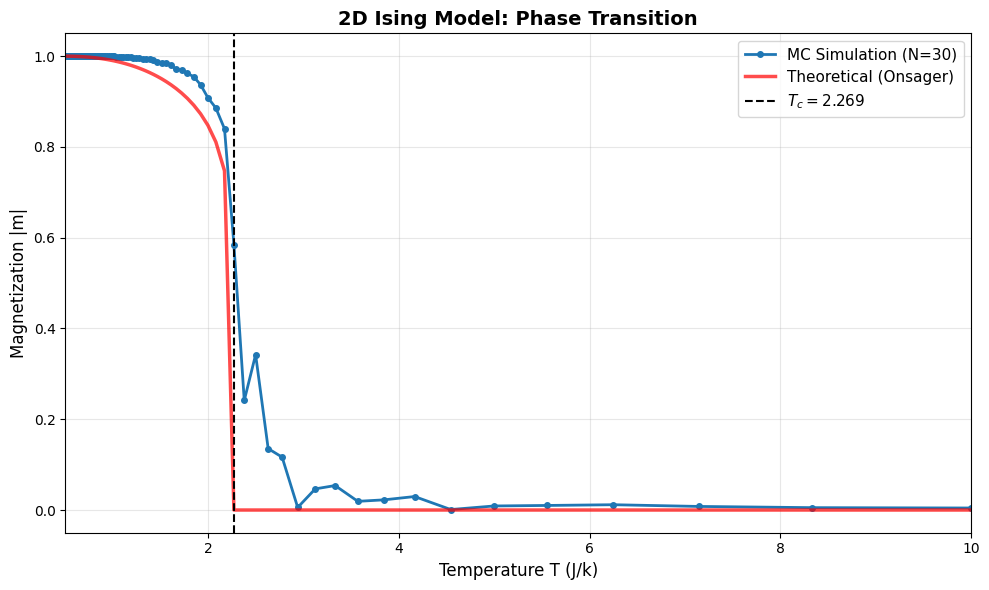

In [ ]:
###---PHASE TRANSITION ANALYSIS

N = 30
BJs = np.arange(0.1, 2.0, 0.02)
temperatures = 1 / BJs

print(f"Simulating phase transition...")
print(f"Lattice size: {N} × {N}")
print(f"Temperature range: {temperatures[0]:.2f} to {temperatures[-1]:.2f}")
print(f"Critical temperature: Tc ≈ 2.269")
print()

# Run phase transition scan
results = IsingAnalysis.phase_transition_scan(
    N=N,
    temperatures=temperatures,
    timesteps=100000,
    threshold=1  # Start from all spin-up
)

# Plot phase transition
vis = IsingVisualizer()
vis.plot_phase_transition(results, N)


Lattice size: 100 × 100
Field strength: H0 = 5



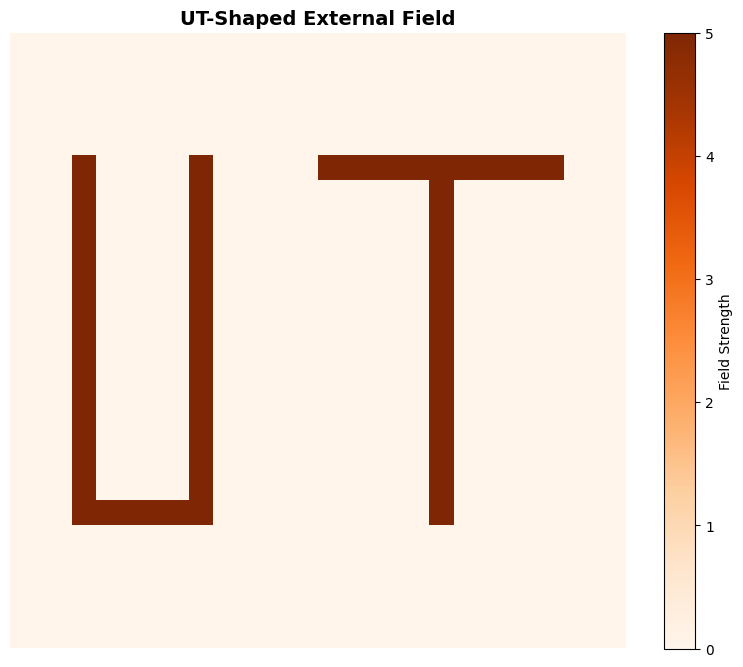

Captured 10 snapshots


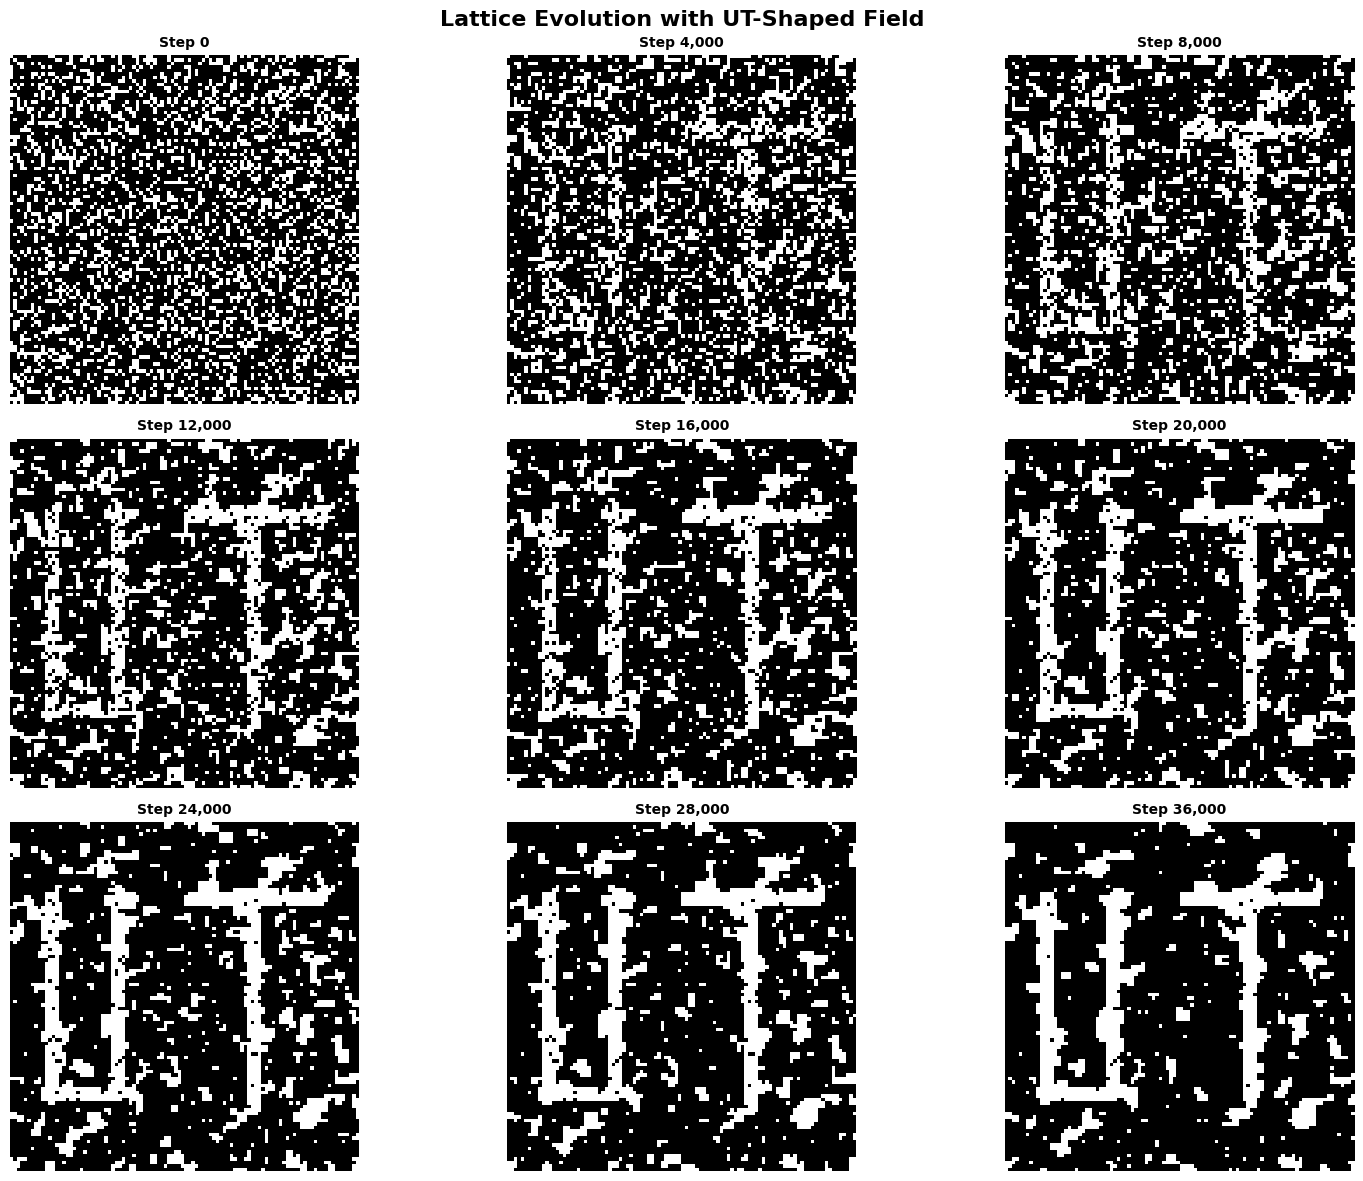

In [ ]:
###---POSITION DEPENDENT UT-SHAPED FIELD

N_field = 100
ut_field = UTField(H0=5)

print(f"Lattice size: {N_field} × {N_field}")
print(f"Field strength: H0 = 5")
print()

vis.plot_field(ut_field.position_dependent(N_field), "UT-Shaped External Field")

model_ut = IsingModel(N=N_field, temperature=1.0, external_field=ut_field)
model_ut.initialize_lattice(threshold=0.7)

spins, energies, final, snaps, times = model_ut.metropolis_with_snapshots(
    timesteps=40000, snapshot_interval=4000
)

print(f"Captured {len(snaps)} snapshots")
vis.plot_snapshots(snaps, times, "Lattice Evolution with UT-Shaped Field")



Simulating with oscillating field H(t) = 10*cos(π*0.00005*t)...
Lattice size: 50 × 50
Time steps: 100,000



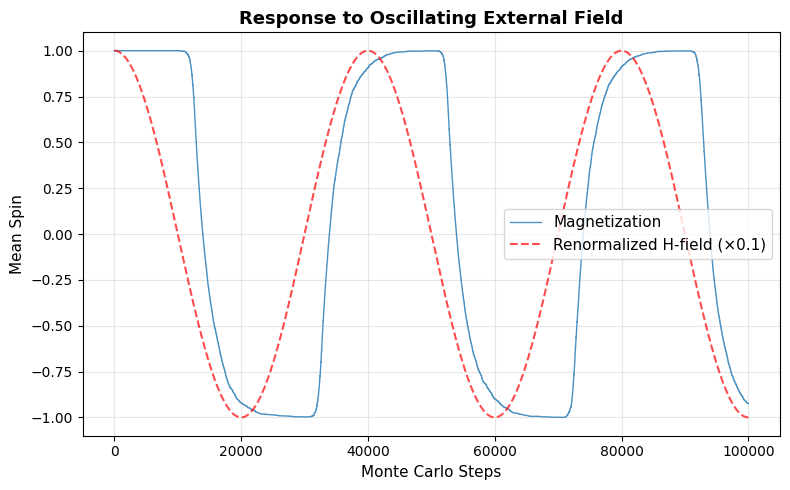

In [ ]:
###---TIME-DEPENDENT OSCILLATING FIELD
N_osc = 50
osc_field = OscillatingField(amplitude=10.0, omega=0.00005)
timesteps_osc = 100000

print(f"Simulating with oscillating field H(t) = 10*cos(π*0.00005*t)...")
print(f"Lattice size: {N_osc} × {N_osc}")
print(f"Time steps: {timesteps_osc:,}")
print()

model_osc = IsingModel(N=N_osc, temperature=1.0, external_field=osc_field)
model_osc.initialize_lattice(threshold=0.0)  # Start all spin down

spins_osc, energies_osc, final_osc = model_osc.metropolis_with_field(timesteps_osc)

# Plot magnetization vs field
t = np.arange(0, timesteps_osc - 1, 1)
field_values = osc_field.time_dependent(t)

plt.figure(figsize=(8, 5))
plt.plot(t, spins_osc / N_osc**2, linewidth=1, label='Magnetization', alpha=0.8)
plt.plot(t, 0.1 * field_values, '--', linewidth=1.5,
          label='Renormalized H-field (×0.1)', alpha=0.7, color='red')
plt.xlabel('Monte Carlo Steps', fontsize=11)
plt.ylabel('Mean Spin', fontsize=11)
plt.title('Response to Oscillating External Field', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Below is a numpy implementation of the model, with an external field.

In [ ]:
###---Square ising model in numpy with external field

import numpy as np
import matplotlib.pyplot as plt


#  Unified Ising model with position-dependent and uniform field
class IsingModel:
    def __init__(self, size: int, J: float = 1.0, field: np.ndarray | None = None):
        """
        size   : linear lattice size (size x size)
        J      : nearest-neighbor coupling
        field  : position-dependent external field H[i,j] (same shape as lattice),
                 in energy units. If None, no position-dependent field.
        """
        self.size = size
        self.J = J
        self.state = None
        self.field = field  # H_ij
        self.h_history = []  # will store uniform/time-dependent field if used

    def set_field(self, field: np.ndarray):
        """Attach / change the position-dependent external field."""
        assert field.shape == (self.size, self.size), "field must match lattice size"
        self.field = field

    def initialize_random(self, spin_up_fraction=0.5):
        """
        Create a size x size lattice of spins in {-1, +1},
        with given fraction of +1 spins.
        """
        self.state = np.random.choice(
            [-1, 1],
            size=(self.size, self.size),
            p=[1 - spin_up_fraction, spin_up_fraction],
        )
        return self.state

    def energy(self, state=None, h: float = 0.0):
        """
        Total energy:
        E = -J Σ_<ij> s_i s_j - Σ_i H_i s_i - h Σ_i s_i

        where:
          - H_i is the position-dependent field (self.field[i,j]) if provided,
          - h is an optional uniform field (possibly time-dependent).
        """
        if state is None:
            state = self.state

        # nearest-neighbor interactions with periodic BCs
        E = 0.0
        # vertical bonds
        E -= self.J * np.sum(state * np.roll(state, -1, axis=0))
        # horizontal bonds
        E -= self.J * np.sum(state * np.roll(state, -1, axis=1))

        # position-dependent field
        if self.field is not None:
            E -= np.sum(self.field * state)

        # uniform field
        if h != 0.0:
            E -= h * np.sum(state)

        return E

    def local_energy_change(self, i, j, h: float = 0.0):
        """
        ΔE for flipping spin at (i,j) with position-dependent + uniform field:

        ΔE = 2 s_ij ( J Σ_neighbors s_neighbor + H_ij + h )
        """
        s = self.state[i, j]

        # sum of 4 nearest neighbors (periodic BC)
        neighbors_sum = (
            self.state[(i + 1) % self.size, j] +
            self.state[(i - 1) % self.size, j] +
            self.state[i, (j + 1) % self.size] +
            self.state[i, (j - 1) % self.size]
        )

        H_ij = 0.0 if self.field is None else self.field[i, j]

        return 2.0 * s * (self.J * neighbors_sum + H_ij + h)

    def magnetization(self, state=None):
        """Average spin per site."""
        if state is None:
            state = self.state
        return np.mean(state)

    def simulate(self, temperature, n_steps, h_func=None, sample_every=100):
        """
        Metropolis simulation with optional time-dependent uniform field h_func(step).

        Records state, energy, and magnetization every `sample_every` MC steps.
        Also stores the uniform h(t) samples in self.h_history.

        Returns
        -------
        states : list of 2D arrays
        energies : list of floats
        magnetizations : list of floats
        """
        # initial sample at "step 0"
        states = [self.state.copy()]
        h0 = h_func(0) if h_func is not None else 0.0
        energies = [self.energy(h=h0)]
        magnetizations = [self.magnetization()]
        h_history = [h0]

        for step in range(n_steps):
            # uniform field at this MC step
            h = h_func(step) if h_func is not None else 0.0

            # pick random spin
            i = np.random.randint(0, self.size)
            j = np.random.randint(0, self.size)

            # Metropolis criterion
            dE = self.local_energy_change(i, j, h=h)
            if dE < 0 or np.random.rand() < np.exp(-dE / temperature):
                self.state[i, j] *= -1

            # sample every `sample_every` steps
            if (step + 1) % sample_every == 0:
                states.append(self.state.copy())
                energies.append(self.energy(h=h))
                magnetizations.append(self.magnetization())
                h_history.append(h)

        self.h_history = h_history
        return states, energies, magnetizations

    def run(self, T: float, n_steps: int, sample_interval: int = 10_000):
        """
        Convenience wrapper (no uniform field) to mimic your UT code:

        Returns
        -------
        snapshots : list of 2D spin arrays
        times     : list of MC step indices for each snapshot
        """
        states, _, _ = self.simulate(
            temperature=T,
            n_steps=n_steps,
            h_func=None,
            sample_every=sample_interval,
        )

        # times corresponding to the initial state and each sample
        times = [0] + [sample_interval * k for k in range(1, len(states))]
        return states, times


#  Theoretical magnetization (exact 2D Ising)
def theoretical_magnetization(T, J=1.0, k=1.0):
    """
    Exact 2D Ising magnetization (Onsager/Yang result) for T < Tc,
    and 0 for T > Tc.
    """
    Tc = 2.269185 * J / k
    if T > Tc:
        return 0.0
    else:
        z = np.exp(-2 * J / (k * T))
        return (1 + z**2)**0.25 * (1 - 6 * z**2 + z**4)**0.125



#  Monte Carlo magnetization vs temperature (average over runs)
def mag_vs_temperature(
    size,
    temps,
    J=1.0,
    n_steps=200000,
    n_runs=5,
    spin_up_fraction=0.7,
):
    """
    For each temperature T in temps:
      - run n_runs independent simulations
      - use magnetization time series from simulate()
      - average |m| over the remaining samples
    Returns an array of smoothed magnetizations vs T.
    """
    mags_T = []

    for T in temps:
        print(f"\nSimulating (mag vs T) at T = {T:.3f}")
        run_mags = []

        for run in range(n_runs):
            model = IsingModel(size=size, J=J)
            model.initialize_random(spin_up_fraction=spin_up_fraction)

            # record every 100 steps (same as your old code)
            _, _, mags = model.simulate(
                temperature=T,
                n_steps=n_steps,
                h_func=None,
                sample_every=1000,
            )
            temp = np.abs(mags[-10:])# take the average for the last few mag
            run_mags.append(np.mean(temp))

        run_ave = np.mean(run_mags)
        mags_T.append(run_ave)

    return np.array(mags_T)


# UT-shaped position-dependent field H_ij
def create_UT_field(size: int, H0: float = 2.0) -> np.ndarray:
    """
    Create a size x size field matrix H, where H = H0 in the regions
    shaped like the letters "U" and "T", and 0 elsewhere.
    """
    H = np.zeros((size, size), dtype=float)

    # geometry parameters in pixels
    t = max(1, size // 25)     # stroke thickness
    top = size // 5
    bottom = 4 * size // 5

    # ----- U letter -----
    u_left = size // 10
    u_right = size // 3

    # two vertical bars
    H[top:bottom, u_left:u_left + t] = H0
    H[top:bottom, u_right - t:u_right] = H0

    # bottom bar
    H[bottom - t:bottom, u_left:u_right] = H0

    # ----- T letter -----
    t_left = size // 2
    t_right = 9 * size // 10

    # top horizontal bar
    H[top:top + t, t_left:t_right] = H0

    # vertical stem in the middle
    t_center = (t_left + t_right) // 2
    H[top:bottom, t_center - t // 2 : t_center + (t + 1) // 2] = H0

    return H


Simulating (mag vs T) at T = 2.000

Simulating (mag vs T) at T = 2.100

Simulating (mag vs T) at T = 2.200

Simulating (mag vs T) at T = 2.300

Simulating (mag vs T) at T = 2.400

Simulating (mag vs T) at T = 2.500

Simulating (mag vs T) at T = 2.600


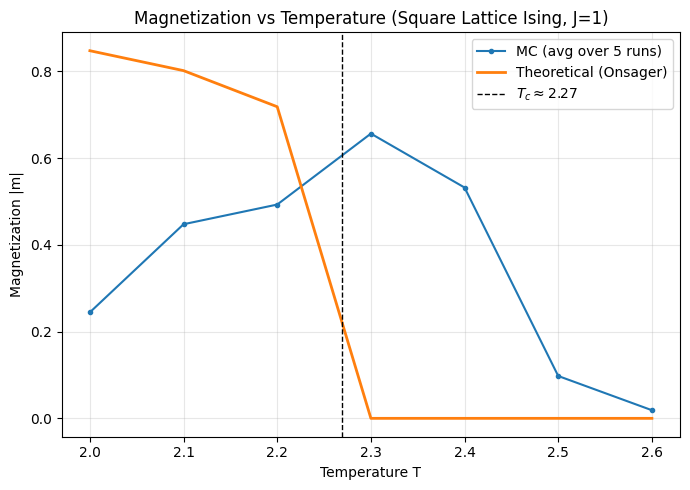

In [ ]:

###---Magnetization vs temperature (average over 5 runs)
#    + Theoretical magnetization curve overlay

temps = np.arange(2.0, 2.6, 0.1)

square_mag = mag_vs_temperature(
    size=50,
    temps=temps,
    J=1.0,
    n_steps=200000,
    n_runs=1,
    spin_up_fraction=0.4,
)

# Theoretical magnetization (same temperature grid for easy comparison)
theory_mag = np.array([theoretical_magnetization(T, J=1.0, k=1.0) for T in temps])

plt.figure(figsize=(7, 5))
plt.plot(temps, square_mag, 'o-', markersize=3, label='MC (avg over 5 runs)')
plt.plot(temps, theory_mag, '-', linewidth=2, label='Theoretical (Onsager)')
plt.axvline(2.269185, color='k', linestyle='--', linewidth=1, label=r'$T_c \approx 2.27$')

plt.xlabel('Temperature T')
plt.ylabel('Magnetization |m|')
plt.title('Magnetization vs Temperature (Square Lattice Ising, J=1)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#Theoretical Magnetization vs temperature
temps = np.arange(1.5, 3.0, 0.02)

plt.figure(figsize=(7, 5))
plt.plot(temps, theory_mag, '-', linewidth=2, label='Theoretical (Onsager)')
plt.axvline(2.269185, color='k', linestyle='--', linewidth=1, label=r'$T_c \approx 2.27$')

plt.xlabel('Temperature T')
plt.ylabel('Magnetization |m|')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


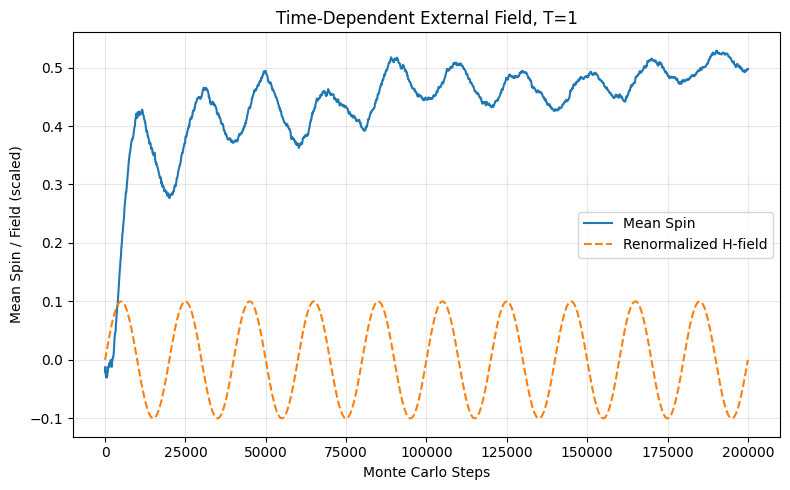

In [ ]:
####----Time-dependent external field: mean spin (magnetization) vs time
#  and field vs time


def time_dependent_field(step, H0=0.2, period=20_000):
    """
    Simple sinusoidal time-dependent external field H(t).
    step: Monte Carlo step index
    H0:   field amplitude
    period: period in MC steps
    """
    return H0 * np.sin(2 * np.pi * step / period)


N = 50
T_ext = 1          # temperature for the external-field run
n_steps_ext = 200_000

model_ext = IsingModel(size=N, J=1.0)
model_ext.initialize_random(spin_up_fraction=0.5)

# Run with time-dependent field; h_func is sampled at every MC step
_, energies_ext, mags_ext = model_ext.simulate(
    temperature=T_ext,
    n_steps=n_steps_ext,
    h_func=lambda step: time_dependent_field(step, H0=0.5, period=20_000)
)

mags_ext = np.array(mags_ext)          # magnetization samples (every 100 MC steps)
h_hist = np.array(model_ext.h_history) # external field at the same sampling times

# "Time" axis in units of 100 MC steps, similar to how we recorded samples
t_samples = 100 * np.arange(len(mags_ext))

plt.figure(figsize=(8, 5))
plt.plot(t_samples, mags_ext, label='Mean Spin')
# Rescale field so it fits nicely on the same plot (like your 0.1 * H(t))
plt.plot(t_samples, 0.2 * h_hist, '--', label='Renormalized H-field')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Mean Spin / Field (scaled)')
plt.title(f'Time-Dependent External Field, T={T_ext}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


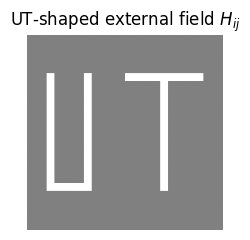

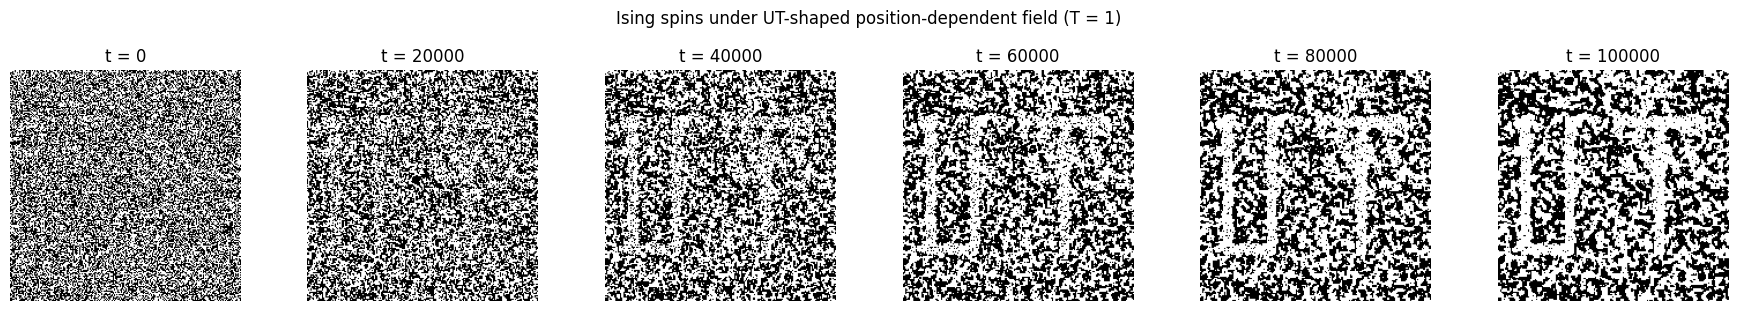

In [ ]:
###----Simulate Square Ising model with UT-shaped field and visualize

N = 200         # lattice size
J = 1.0
T = 1           # temperature (in J/k_B units)
n_steps = 100000  # total MC steps
sample_interval = 20000  # how often to record a snapshot

# Create UT-shaped position-dependent field
H_UT = create_UT_field(N, H0=2.0)

# Visualize the field itself
plt.figure(figsize=(2.5, 2.5))
plt.title("UT-shaped external field $H_{ij}$")
plt.imshow(H_UT,cmap="gray", vmin=-1, vmax=1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Initialize Ising model with this field
model = IsingModel(size=N, J=J, field=H_UT)
model.initialize_random(spin_up_fraction=0.5)

# Run dynamics and record snapshots
snapshots, times = model.run(T=T, n_steps=n_steps, sample_interval=sample_interval)

# Plot evolution: initial + a few later times
n_snap = len(snapshots)
plt.figure(figsize=(3 * n_snap, 3))

for k, (state, t_step) in enumerate(zip(snapshots, times)):
    ax = plt.subplot(1, n_snap, k + 1)
    ax.imshow(state, cmap="gray", vmin=-1, vmax=1)
    ax.set_title(f"t = {t_step}")
    ax.axis("off")

plt.suptitle(f"Ising spins under UT-shaped position-dependent field (T = {T})",
              y=1.02)
plt.tight_layout()
plt.show()


from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from IPython.display import HTML, display

def animate_ut_field(N=100, H0=2.0, J=1.0, T=1.0, n_steps=500000, sample_interval=20000, cmap='gray', interval=500):
    """
    Create a FuncAnimation of Ising lattice evolution under the UT-shaped, position-dependent field.
    - Keep sample_interval large enough so number of frames = 1 + n_steps//sample_interval is reasonable.
    """
    H_UT = create_UT_field(N, H0=H0)
    model = IsingModel(size=N, J=J, field=H_UT)
    model.initialize_random(spin_up_fraction=0.5)

    # run returns sampled states and their times
    snapshots, times = model.run(T=T, n_steps=n_steps, sample_interval=sample_interval)

    fig, ax = plt.subplots(figsize=(6, 6))
    burntmap = ListedColormap(['white', '#BF5700'])
    im = ax.imshow(snapshots[0], cmap=burntmap, vmin=-1, vmax=1, interpolation='nearest')
    ax.axis('off')
    title = ax.set_title(f"t = {times[0]}  T={T}, H0={H0}")

    def update(frame):
        im.set_data(snapshots[frame])
        title.set_text(f"t = {times[frame]}  T={T}, H0={H0}")
        return (im, title)

    anim = FuncAnimation(fig, update, frames=len(snapshots), interval=interval, blit=True, repeat=True)
    plt.close(fig)  # prevent static display of final frame in notebook

    # Inline display in notebook; also returns the animation object for saving
    display(HTML(anim.to_jshtml()))
    return anim

# Example usage (adjust N, n_steps and sample_interval to get ~5–20 frames):
anim = animate_ut_field(N=250, H0=2.0, J=1.0, T=0.5, n_steps=500000, sample_interval=10000, interval=60)
HTML(anim.to_jshtml())